In [41]:
# !pip install wikipedia
# !pip install sklearn
import nltk
nltk.download('stopwords')
import warnings
import random
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import wikipedia
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
import numpy as np
# !pip install bokeh
# !pip install pyLDAvis
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
output_notebook()
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\otili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading BokehJS ...

##### Wikipedia article scraping

In [84]:
def get_articles(result):
    try:
        p = wikipedia.page(result)
    except wikipedia.DisambiguationError as e:
        s = random.choice(e.options)
        p = wikipedia.page(s)
    return p 

topics = ['video games', 'engineering', 'sports']   
NUM_TOPICS = len(topics)

results = [wikipedia.search(topic)[:30] for topic in topics]
results = np.array(results).flatten()
article_pages = [get_articles(results[i]) for i in range(len(results))]

##### Stop words removal, lemmatization + Bag-Of-Words

In [85]:
data = [article_page.content for article_page in article_pages]

In [86]:
pattern = r"[a-z]{2,}"
# pattern = r"[a-zA-Z\-][a-zA-Z\-]{2,}"
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, token_pattern=pattern)
tfidf_data_vectorized = tfidf_vectorizer.fit_transform(data)

bow_vectorizer = CountVectorizer(stop_words='english', lowercase=True, token_pattern=pattern)
bow_data_vectorized = bow_vectorizer.fit_transform(data)


tfidf_df_vectorized = pd.DataFrame(tfidf_data_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

bow_df_vectorized = pd.DataFrame(bow_data_vectorized.toarray(), columns=bow_vectorizer.get_feature_names_out())

In [87]:

# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# print(bow_df_vectorized.columns.tolist())

In [88]:
tfidf_df_vectorized.head()

,aaa,aar,aaron,aarseth,aau,abandon,abandoned,abandonment,abbreviated,abet,...,zodiac,zombie,zombies,zone,zoorkhaneh,zork,zt,zuse,zx,zynga
0,0.006904,0.0,0.000000,0.009144,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.004572,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.024376,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,0.010437,0.0,0.003081,0.000000,0.0,0.0,0.003456,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.002815,0.0,0.006912,0.003456,0.0,0.011262,0.006163


In [89]:
bow_df_vectorized.head()

,aaa,aar,aaron,aarseth,aau,abandon,abandoned,abandonment,abbreviated,abet,...,zodiac,zombie,zombies,zone,zoorkhaneh,zork,zt,zuse,zx,zynga
0,2,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,2,1,0,4,2


##### Latent Semantic Analysis with SVD

In [90]:
lsi_model = TruncatedSVD(n_components=NUM_TOPICS, n_iter=20)
lsi_tfidf = lsi_model.fit_transform(tfidf_data_vectorized)
lsi_bow = lsi_model.fit_transform(bow_data_vectorized)
print(lsi_tfidf.shape) 

(30, 3)


##### Non-negative matrix factorization

In [91]:
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_tfidf = nmf_model.fit_transform(tfidf_data_vectorized)
print(nmf_tfidf.shape)

(30, 3)


In [92]:
nmf_model = NMF(n_components=NUM_TOPICS, max_iter=500)
nmf_bow = nmf_model.fit_transform(bow_data_vectorized)
print(nmf_bow.shape)

(30, 3)


##### LDA

In [93]:
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_tfidf = lda_model.fit_transform(tfidf_data_vectorized)
lda_bow = lda_model.fit_transform(bow_data_vectorized)

In [94]:
def top_per_topic(model, vectorizer, top_n=5):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

Bag-Of-Words

In [95]:
print("LDA Model:")
top_per_topic(lda_model, bow_vectorizer)
print('--------------- \n')
 
print("NMF Model:")
top_per_topic(nmf_model, bow_vectorizer)
print('--------------- \n')
 
 
print("LSI Model:")
top_per_topic(lsi_model, bow_vectorizer)
print('--------------- \n')


LDA Model:
Topic 0:
[('sports', 439.8753851751154), ('women', 271.2417893086344), ('engineering', 222.47862598560283), ('propaganda', 162.1947905538024), ('software', 153.5820398387064)]
Topic 1:
[('engineering', 298.6765460242191), ('game', 298.3158682139962), ('engineers', 70.14595164175566), ('games', 67.64654358910342), ('civil', 62.73560908497773)]
Topic 2:
[('games', 1155.0437529457247), ('game', 715.3775685729246), ('video', 571.5254944165076), ('list', 385.3059107274836), ('industry', 159.60633641153294)]
--------------- 

NMF Model:
Topic 0:
[('game', 20.71515668051552), ('games', 14.816442480649252), ('video', 8.125985344400432), ('industry', 3.029339350796871), ('console', 2.8871380306896697)]
Topic 1:
[('women', 20.412533592351945), ('sports', 17.897550249420693), ('female', 7.43493765317295), ('sport', 6.492195786853963), ('men', 5.770470627606667)]
Topic 2:
[('games', 27.974996573464956), ('list', 27.43288752092575), ('video', 11.483141225085586), ('developed', 2.38068885

TF-IDF Vectorization

In [96]:
print("LDA Model:")
top_per_topic(lda_model, tfidf_vectorizer)
print('--------------- \n')
 
print("NMF Model:")
top_per_topic(nmf_model, tfidf_vectorizer)
print('--------------- \n')
 
 
print("LSI Model:")
top_per_topic(lsi_model, tfidf_vectorizer)
print('--------------- \n')

LDA Model:
Topic 0:
[('sports', 439.8753851751154), ('women', 271.2417893086344), ('engineering', 222.47862598560283), ('propaganda', 162.1947905538024), ('software', 153.5820398387064)]
Topic 1:
[('engineering', 298.6765460242191), ('game', 298.3158682139962), ('engineers', 70.14595164175566), ('games', 67.64654358910342), ('civil', 62.73560908497773)]
Topic 2:
[('games', 1155.0437529457247), ('game', 715.3775685729246), ('video', 571.5254944165076), ('list', 385.3059107274836), ('industry', 159.60633641153294)]
--------------- 

NMF Model:
Topic 0:
[('game', 20.71515668051552), ('games', 14.816442480649252), ('video', 8.125985344400432), ('industry', 3.029339350796871), ('console', 2.8871380306896697)]
Topic 1:
[('women', 20.412533592351945), ('sports', 17.897550249420693), ('female', 7.43493765317295), ('sport', 6.492195786853963), ('men', 5.770470627606667)]
Topic 2:
[('games', 27.974996573464956), ('list', 27.43288752092575), ('video', 11.483141225085586), ('developed', 2.38068885

In [97]:
text = 'In the video game industry, 2020 saw the launch of the next generation of video game consoles, with both Microsoft and Sony Interactive Entertainment having released the Xbox Series X/S and PlayStation'
x = nmf_model.transform(tfidf_vectorizer.transform([text]))[0]

In [98]:
x

array([0.01412776, 0.        , 0.        ])

##### Similarity function

In [99]:
def most_similar(x, Z, top_n=5):
    dists = euclidean_distances(x.reshape(1, -1), Z)
    # print(dists[0], np.argmin(dists[0]))
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return dists, most_similar
 
dists, similarities = most_similar(x, nmf_tfidf)
document_id, similarity = similarities[0]
print(data[document_id][:200])

Propaganda is communication that is primarily used to influence or persuade an audience to further an agenda, which may not be objective and may be selectively presenting facts to encourage a particul


#### Plotting

In [100]:
pyLDAvis.enable_notebook()
panel_tfidf = pyLDAvis.sklearn.prepare(lda_model, tfidf_data_vectorized, tfidf_vectorizer, mds='mmds')
print(panel_tfidf.topic_info[:10])
panel_tfidf

              Term  Freq  Total Category  logprob  loglift
4362         games   5.0    5.0  Default     30.0     30.0
4342          game   4.0    4.0  Default     29.0     29.0
11075        video   2.0    2.0  Default     28.0     28.0
3507   engineering   3.0    3.0  Default     27.0     27.0
6034          list   1.0    1.0  Default     26.0     26.0
11381        women   1.0    1.0  Default     25.0     25.0
9799        sports   3.0    3.0  Default     24.0     24.0
8176    propaganda   0.0    0.0  Default     23.0     23.0
2180       console   0.0    0.0  Default     22.0     22.0
9794         sport   0.0    0.0  Default     21.0     21.0


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.023260  0.098170       1        1  39.824663
2      0.092038 -0.050155       2        1  35.343077
1     -0.068778 -0.048015       3        1  24.832260, topic_info=              Term      Freq     Total Category  logprob  loglift
4362         games  5.000000  5.000000  Default  30.0000  30.0000
4342          game  4.000000  4.000000  Default  29.0000  29.0000
11075        video  2.000000  2.000000  Default  28.0000  28.0000
3507   engineering  3.000000  3.000000  Default  27.0000  27.0000
6034          list  1.000000  1.000000  Default  26.0000  26.0000
...            ...       ...       ...      ...      ...      ...
10963          use  0.169576  0.737672   Topic3  -6.2964  -0.0772
6982           new  0.164633  0.842579   Topic3  -6.3260  -0.2397
10256      systems  0.157657  0.702758   Topic3  -6.3693  -0.1016
11075        video  0.170142  2.751130   Topic3  -6.2931  -1.3901
7799       players  0.145374  0.800414   Topic3  -6.4504  -0.3128

[223 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2180       2  1.555499      console
3507       1  0.332026  engineering
3507       3  0.664052  engineering
3966       1  1.627522       female
4342       2  0.606017         game
4342       3  0.404011         game
4362       2  0.878485        games
5239       2  1.152022     industry
6034       2  1.129903         list
8176       1  1.019021   propaganda
9664       1  0.834174     software
9794       1  1.225639        sport
9799       1  0.944921       sports
9799       2  0.314974       sports
11075      2  1.090461        video
11381      1  1.210711        women, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [101]:
panel_bow= pyLDAvis.sklearn.prepare(lda_model, bow_data_vectorized, bow_vectorizer, mds="mmds");
panel_bow

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.030524  0.098604       1        1  43.576706
0      0.052943 -0.087447       2        1  35.975543
1     -0.083468 -0.011157       3        1  20.447752, topic_info=              Term         Freq        Total Category  logprob  loglift
4362         games  1261.000000  1261.000000  Default  30.0000  30.0000
4342          game   999.000000   999.000000  Default  29.0000  29.0000
3507   engineering   484.000000   484.000000  Default  28.0000  28.0000
11075        video   613.000000   613.000000  Default  27.0000  27.0000
6034          list   400.000000   400.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
10963          use    25.963438   138.092707   Topic3  -6.2964  -0.0839
6982           new    25.206628   160.915461   Topic3  -6.3260  -0.2665
10256      systems    24.138540   131.185183   Topic3  -6.3693  -0.1055
11075        video    26.050013   613.595245   Topic3  -6.2931  -1.5720
7799       players    22.257969   161.054981   Topic3  -6.4504  -0.3917

[224 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
247        1  0.103699  aggregate
247        3  0.829588  aggregate
521        1  0.930580      apple
521        2  0.066470      apple
521        3  0.066470      apple
...      ...       ...        ...
11415      1  0.065650      worst
11415      2  0.043767      worst
11415      3  0.875337      worst
11490      1  0.100124      youth
11490      2  0.901113      youth

[505 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

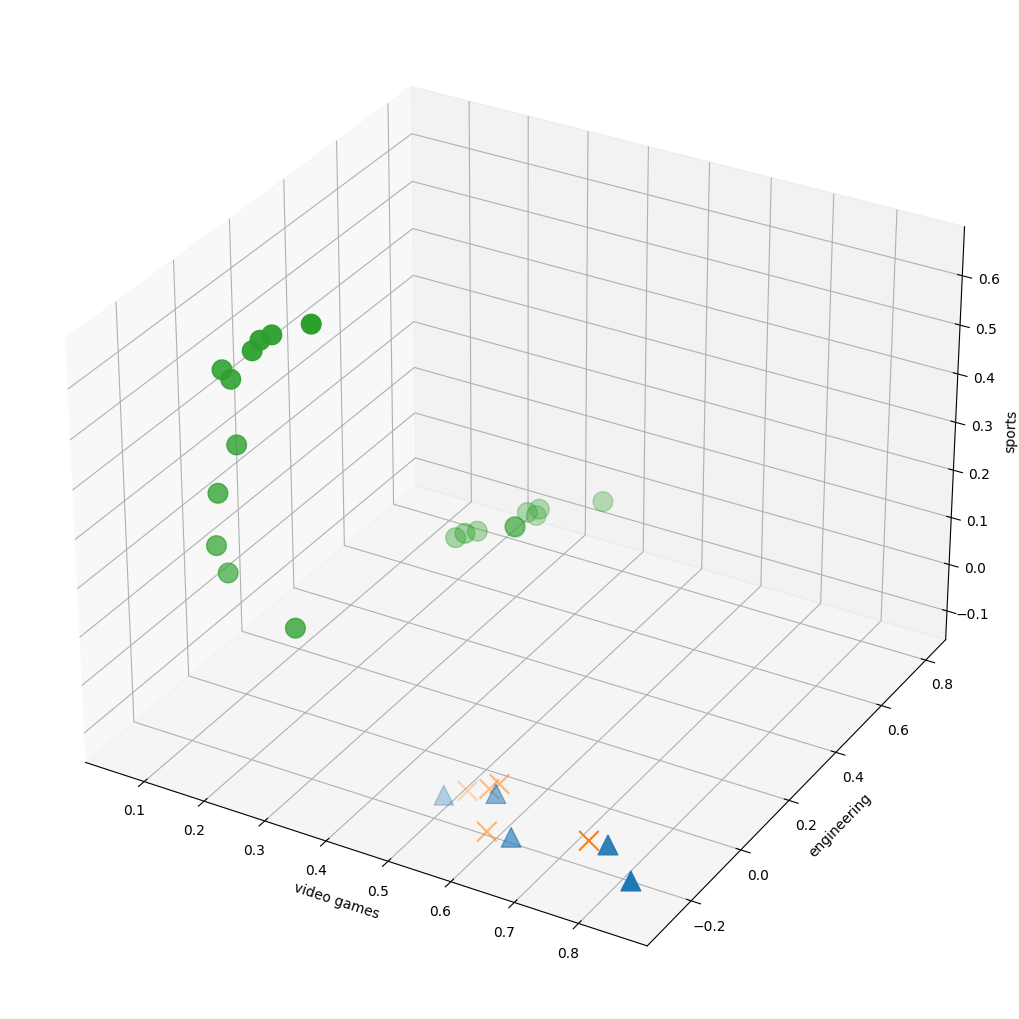

In [111]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

xs = lsi_tfidf[:,0]
ys = lsi_tfidf[:,1]
zs = lsi_tfidf[:,2]
ax.scatter(xs[:5], ys[:5], zs[:5], marker='^', s=200)
ax.scatter(xs[5:10], ys[5:10], zs[5:10], marker='x', s=200)
ax.scatter(xs[10:], ys[10:], zs[10:], marker='o', s=200)

ax.set_xlabel(topics[0])
ax.set_ylabel(topics[1])
ax.set_zlabel(topics[2]);

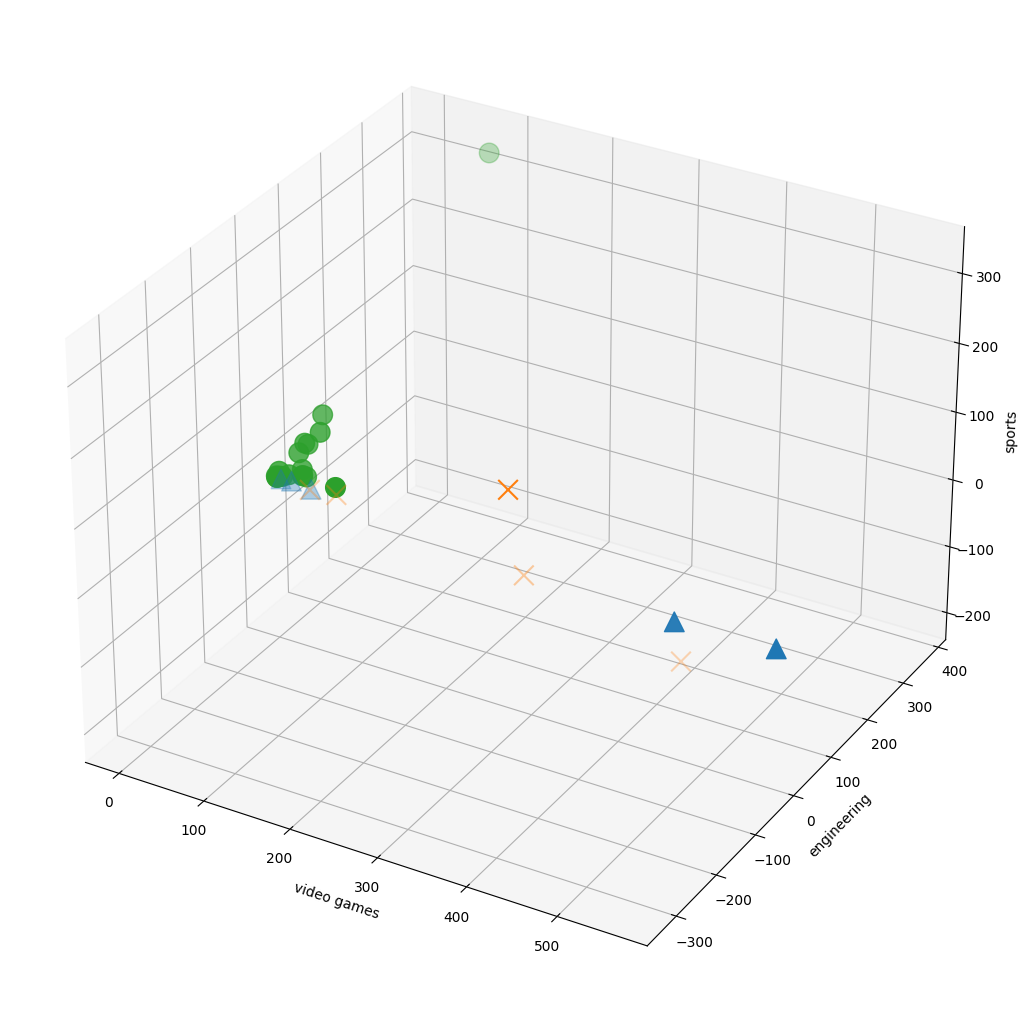

In [112]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
 

xs = lsi_bow[:,0]
ys = lsi_bow[:,1]
zs = lsi_bow[:,2]
ax.scatter(xs[:5], ys[:5], zs[:5], marker='^', s=200)
ax.scatter(xs[5:10], ys[5:10], zs[5:10], marker='x', s=200)
ax.scatter(xs[10:], ys[10:], zs[10:], marker='o', s=200)

ax.set_xlabel(topics[0])
ax.set_ylabel(topics[1])
ax.set_zlabel(topics[2]);

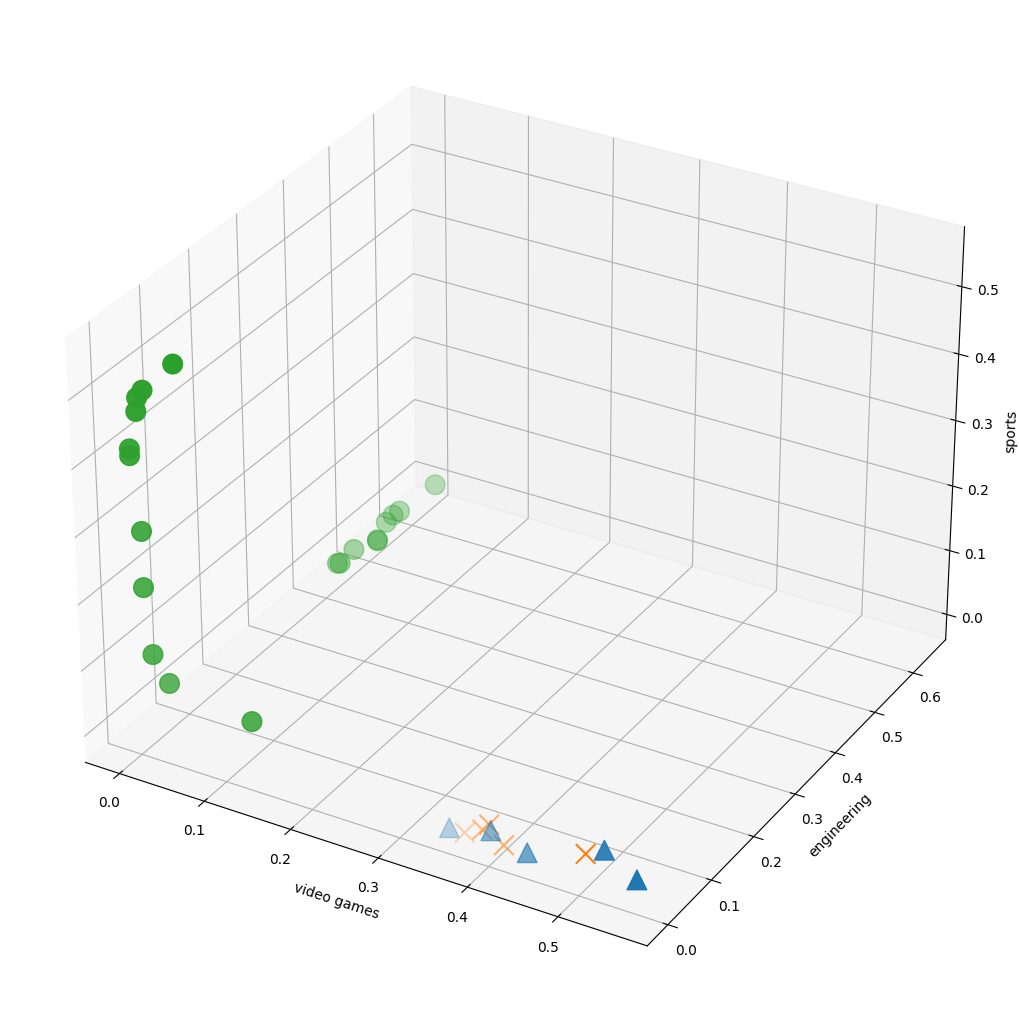

In [113]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
 

xs = nmf_tfidf[:,0]
ys = nmf_tfidf[:,1]
zs = nmf_tfidf[:,2]
ax.scatter(xs[:5], ys[:5], zs[:5], marker='^', s=200)
ax.scatter(xs[5:10], ys[5:10], zs[5:10], marker='x', s=200)
ax.scatter(xs[10:], ys[10:], zs[10:], marker='o', s=200)

ax.set_xlabel(topics[0])
ax.set_ylabel(topics[1])
ax.set_zlabel(topics[2]);

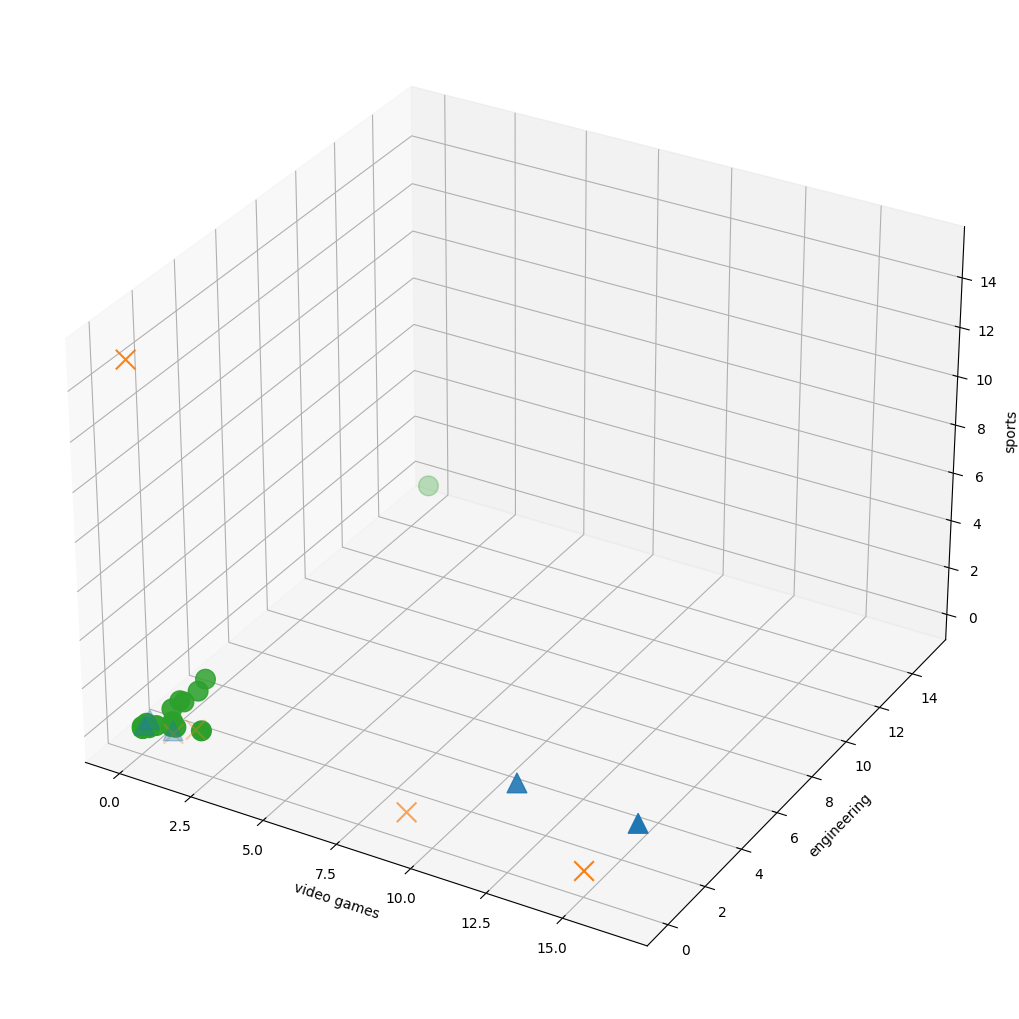

In [115]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
 
xs = nmf_bow[:,0]
ys = nmf_bow[:,1]
zs = nmf_bow[:,2]

ax.scatter(xs[:5], ys[:5], zs[:5], marker='^', s=200)
ax.scatter(xs[5:10], ys[5:10], zs[5:10], marker='x', s=200)
ax.scatter(xs[10:], ys[10:], zs[10:], marker='o', s=200)

ax.set_xlabel(topics[0])
ax.set_ylabel(topics[1])
ax.set_zlabel(topics[2]);